In [78]:
import hashlib
import pandahouse
import pandas as pd
import swifter
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import numpy as np

In [79]:
sns.set(rc={'figure.figsize':(10,5)})

## Exercise 2 (A/B testing)

In [80]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [81]:
q_ctr = '''SELECT user_id, exp_group, countIf(action='like') likes, countIf(action='view') views, countIf(action='like')/countIf(action='view') ctr
from simulator_20220520.feed_actions 
group by user_id, exp_group
having toDate(time)>='2022-04-24' and toDate(time)<='2022-04-30' and exp_group in (1,2) 
'''

In [82]:
df_ctr = pandahouse.read_clickhouse(query=q_ctr, connection=connection)

In [83]:
df_ctr['exp_group'].replace(1,'control', inplace=True)
df_ctr['exp_group'].replace(2,'test', inplace=True)

In [84]:
# проверяем базовые статистики по тестовой и контрольной группам. Средний ctr по группам очень похожее, для тестового чуть меньше (21,44% против 21,56%). 
# Однако разброс (станд откл-е) по тестовой выборке намного выше. Кроме того, видно, что крайние квартили по тестовой выборке также сильно отличаются от контрольной.
(df_ctr.groupby('exp_group').ctr.describe())

,count,mean,std,min,25%,50%,75%,max
exp_group,,,,,,,,
control,10079.0,0.215605,0.08416,0.0,0.160097,0.203125,0.257654,0.722222
test,9952.0,0.214419,0.14418,0.0,0.095238,0.142857,0.325000,0.923077


<AxesSubplot:xlabel='ctr', ylabel='Count'>

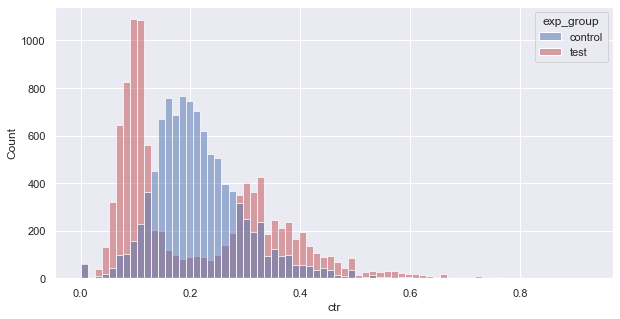

In [85]:
# Гистограмма показывает что-то неожиданное. Для тестовой выборки есть 2 горба - в районе 10% и в районе 30%. Горб в районе 10% кажется больше (второй менее размазан).
# Для контрольной как раньше - распределение похоже на нормальное с центром в районе 20%.
# Похоже, что эксперимент дал полярные результаты - у кого-то ухудшил ключевую метрику, у кого-то наоборот увеличил. 
# Надо будет изучить эти группы (1 - у кого ухудшили и 2 - у кого улучшили) отдельно - по профилю (ос, пол-возраст и тд) и поведению (кол-во просмотров и тд).
sns.histplot(data=df_ctr, x='ctr', hue='exp_group', palette=['b','r'])

### т-тест Стьюдента

In [86]:
# стандартный т-тест дает pvalue сильно больше 0.05, то есть выборки как бы одинаковые.
_, pvalue = stats.ttest_ind(df_ctr[df_ctr['exp_group']=='test'].ctr, df_ctr[df_ctr['exp_group']=='control'].ctr,
                            equal_var=False)
pvalue

0.4780623130874935

### Пуассоновский бутстреп

In [87]:
df_ctr_tst = df_ctr[df_ctr['exp_group']=='test']
df_ctr_ctrl = df_ctr[df_ctr['exp_group']=='control']

In [88]:
n_test = df_ctr_tst.shape[0]
n_control = df_ctr_ctrl.shape[0]

In [89]:
n_samples = 5000

poisson_samples_tst = stats.poisson(1).rvs((n_samples, n_test))
poisson_samples_ctrl = stats.poisson(1).rvs((n_samples, n_control))

<AxesSubplot:ylabel='Count'>

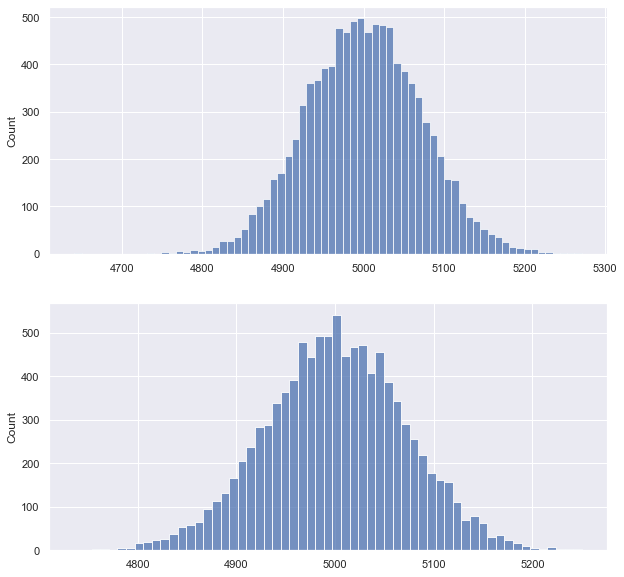

In [90]:
# проверяем разброс выборок - сколько раз выпадало каждое из значений
fig, ax = plt.subplots(2, figsize=(10,10))
sns.histplot(sum(poisson_samples_tst), ax=ax[0])
sns.histplot(sum(poisson_samples_ctrl), ax=ax[1])

In [91]:
# считаем глобальный ctr для каждой выборки. отдельно для тестовых и отдельно для контрольных.
ctr_pois_tst = (poisson_samples_tst * df_ctr_tst.likes.to_numpy()).sum(axis=1) / (poisson_samples_tst * df_ctr_tst.views.to_numpy()).sum(axis=1)
ctr_pois_ctrl = (poisson_samples_ctrl * df_ctr_ctrl.likes.to_numpy()).sum(axis=1) / (poisson_samples_ctrl * df_ctr_ctrl.views.to_numpy()).sum(axis=1)

<AxesSubplot:ylabel='Count'>

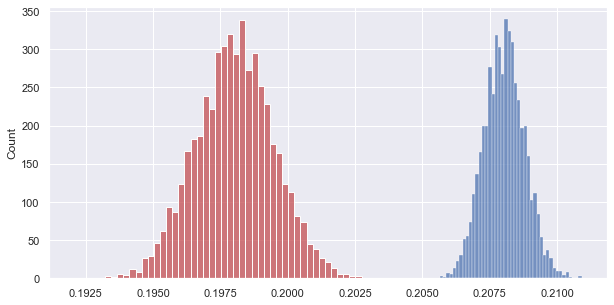

In [92]:
# Тестовые - красные, контрольные - синие. Разница проявилась в отличие от т-теста. 
# Однако тестовые значения ниже чем контрольные.
sns.histplot(ctr_pois_tst, color='r')
sns.histplot(ctr_pois_ctrl, color='b')

<AxesSubplot:ylabel='Count'>

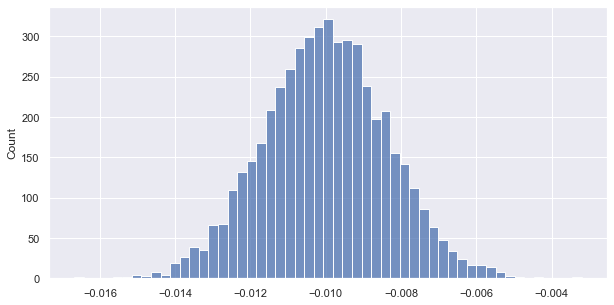

In [93]:
# все распределение разностей теста и контроля (пуассоновским бутстрепом) находится в отрицальной зоне.
# то есть тестовый ctr значимо меньше контрольного.
sns.histplot(ctr_pois_tst - ctr_pois_ctrl)

### Манна-Уитни

In [94]:
# тест Манна-Уитни показывает p-value около нуля. То есть выборки разные.
_, pvalue_mw = stats.mannwhitneyu(df_ctr_tst.ctr, df_ctr_ctrl.ctr)
pvalue_mw, round(pvalue_mw,10)

(6.0376484617779035e-56, 0.0)

In [95]:
# сравним по случайным значениям из теста и контроля
A_gt_B = 0
n_samples = 10**5

for _ in range(n_samples):
    A_gt_B+= df_ctr_tst.ctr.sample().values[0] > df_ctr_ctrl.ctr.sample().values[0]
    
print('В', round((A_gt_B/n_samples)*100, 2), '% случаев test > control. Должно получиться около 50%')

В 43.42 % случаев test > control. Должно получиться около 50%


Нулевая гипотеза (ранги выборок одинаковые) отвергнута (и по pvalue, и по сравнению случайных значений). То есть распределения выборок разные. 

### Тесты на сглаженном ctr

In [96]:
def smoothed_ctr(like, view, general_ctr, alpha):
    return (like + alpha*general_ctr) / (view + alpha)

In [97]:
# считаем глобальные ctr
global_ctr_tst = df_ctr_tst.likes.sum() / df_ctr_tst.views.sum()
global_ctr_ctrl = df_ctr_ctrl.likes.sum() / df_ctr_ctrl.views.sum()

In [98]:
# сглаженные ctr
df_ctr_tst['smoothed_ctr'] = df_ctr_tst.apply(
    lambda x: smoothed_ctr(x['likes'], x['views'], global_ctr_tst, 5), axis=1)

df_ctr_ctrl['smoothed_ctr'] = df_ctr_ctrl.apply(
    lambda x: smoothed_ctr(x['likes'], x['views'], global_ctr_ctrl, 5), axis=1)

/var/folders/00/jtb7c8xn51902fgjqt4qh5h80000gp/T/ipykernel_46300/3887212470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ctr_tst['smoothed_ctr'] = df_ctr_tst.apply(
/var/folders/00/jtb7c8xn51902fgjqt4qh5h80000gp/T/ipykernel_46300/3887212470.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ctr_ctrl['smoothed_ctr'] = df_ctr_ctrl.apply(


In [99]:
# отличие по средним после сглаживания стало чуть больше (21,4% в контроле против 21,1%)
pd.DataFrame(dict(control =df_ctr_tst.smoothed_ctr.describe(), test = df_ctr_ctrl.smoothed_ctr.describe()))

,control,test
count,9952.000000,10079.000000
mean,0.210740,0.214025
std,0.124768,0.071368
min,0.030947,0.035867
25%,0.105125,0.164535
50%,0.147879,0.203480
75%,0.310896,0.251672
max,0.770631,0.623114


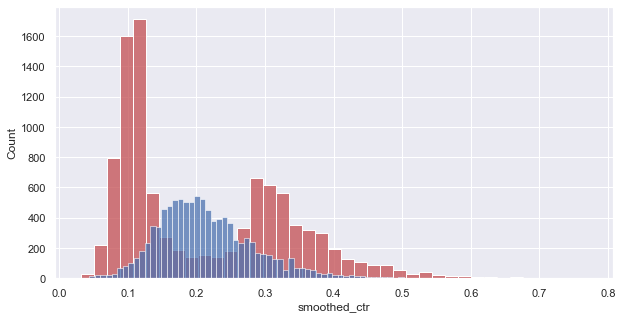

In [100]:
# распределения после сглаживания (красный - тест, синий - контроль). Общая картина распределений не поменялась.
sns.histplot(df_ctr_tst.smoothed_ctr, color='r')
sns.histplot(df_ctr_ctrl.smoothed_ctr, color='b');

In [101]:
# на сглаженных данных т-тест прокрасился.
_, pvalue = stats.ttest_ind(df_ctr_tst.ctr, df_ctr_ctrl.ctr, equal_var=False)
_, pvalue_smoothed = stats.ttest_ind(df_ctr_tst.smoothed_ctr, df_ctr_ctrl.smoothed_ctr, equal_var=False)
print(f'P-value т-теста для сырого ctr = {pvalue}, для сглаженного ctr = {pvalue_smoothed}')

P-value т-теста для сырого ctr = 0.4780623130874935, для сглаженного ctr = 0.0223769815558559


In [102]:
# Манн-Уитни и до этого прокрашивался. Стал еще меньше.
_, pvalue_mw = stats.mannwhitneyu(df_ctr_tst.ctr, df_ctr_ctrl.ctr)
_, pvalue_mw_sm = stats.mannwhitneyu(df_ctr_tst.smoothed_ctr, df_ctr_ctrl.smoothed_ctr)
print(f'P-value теста Манна-Уитни для сырого ctr = {pvalue_mw}, для сглаженного ctr = {pvalue_mw_sm}')

P-value теста Манна-Уитни для сырого ctr = 6.0376484617779035e-56, для сглаженного ctr = 1.6163964114270227e-61


### Бакетное преобразование

In [103]:
# функция для сплитования через хэширование. Делим на 100 групп (мета-юзеров).
def ab_split(id, salt='exp_mess_1', n_groups=100):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [104]:
df_ctr_tst['backet'] = df_ctr_tst.user_id.apply(ab_split)
df_ctr_ctrl['backet'] = df_ctr_ctrl.user_id.apply(ab_split)

/var/folders/00/jtb7c8xn51902fgjqt4qh5h80000gp/T/ipykernel_46300/1297774913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ctr_tst['backet'] = df_ctr_tst.user_id.apply(ab_split)
/var/folders/00/jtb7c8xn51902fgjqt4qh5h80000gp/T/ipykernel_46300/1297774913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ctr_ctrl['backet'] = df_ctr_ctrl.user_id.apply(ab_split)


In [105]:
df_ctr_tst_backet = df_ctr_tst.groupby('backet').likes.sum() / df_ctr_tst.groupby('backet').views.sum()
df_ctr_ctrl_backet = df_ctr_ctrl.groupby('backet').likes.sum() / df_ctr_ctrl.groupby('backet').views.sum()

In [106]:
# после бакетного преобразования т-тест стал еще более четким, чем после сглаживания
_, pvalue = stats.ttest_ind(df_ctr_tst.ctr, df_ctr_ctrl.ctr, equal_var=False)
_, pvalue_backet = stats.ttest_ind(df_ctr_tst_backet, df_ctr_ctrl_backet, equal_var=False)
print(f'P-value т-теста для сырого ctr = {pvalue}, для сглаженного = {pvalue_smoothed}, для бакетного ctr = {pvalue_backet}')

P-value т-теста для сырого ctr = 0.4780623130874935, для сглаженного = 0.0223769815558559, для бакетного ctr = 5.4294865493877956e-08


In [107]:
# Тест Манн-Уитни прокрашивается во всех случаях, после бактеного стал прокрашиваться чуть меньше (возможно из-за уменьшения выборки).
_, pvalue_mw = stats.mannwhitneyu(df_ctr_tst.ctr, df_ctr_ctrl.ctr)
_, pvalue_mw_backet = stats.mannwhitneyu(df_ctr_tst_backet, df_ctr_ctrl_backet)
print(f'P-value теста Манна-Уитни для сырого ctr = {pvalue_mw}, для сглаженного ctr = {pvalue_mw_sm}, для бакетного ctr = {pvalue_mw_backet}')

P-value теста Манна-Уитни для сырого ctr = 6.0376484617779035e-56, для сглаженного ctr = 1.6163964114270227e-61, для бакетного ctr = 2.0110869513991762e-07


### Выводы

- Большинство тестов показали, что выборки не одинаковые. Что в обшем-то очевидно и по взгляду на распределения, а также на квартили. 
- Эксперимент привел к тому, что для одних пользователей CTR стал сильно меньше (упал с примерно 20% до 10%), для других сильно вырос (до 30%). 
- Какие могли быть причины такого результата? Можно их разделить на 2 группы:
    1) Поведение **пользователей**. Разные группы пользователей по-разному реагируют на сам алгоритм - то есть для одних групп он дает ценность, для других снижает. Например, вторым может не нравится, что им "подсовывают" не те посты, к которым они привыкли, им не нравятся изменения вообще и тд. 
    2) Сбой/ошибка в **алгоритме** - для одних он работал хорошо, для других работал криво. Например, он показывал им неправильные посты, которые нравились меньше. Это могут быть как неправильные настройки, так и просто ошибки в алгоритме. 
- В целом эксперимент имеет хороший потенциал, так как для тех, у кого CTR упал, даже если алгоритм нельзя подкрутить, его можно отключить.

### Рекомендации

1) учитывая сильное падение CTR для примерно половины тестовых пользователей, лучше приостановить эксперимент от греха, пока юзеры не начали отваливаться из-за него. 
2) разобраться, в чем проблема. Начать с гипотезы про алгоритмы, так как он под рукой и его легче проанализировать. 
3) изучать 2 группы - у которых CTR вырос, и у которых упал. Как с помощью анализа имеющихся данных, так и (если останутся вопросы) с помощью опроса. Чем они отличаются? Есть ли какие-то базовые характеристики? Если ресурсы позволяют, то можно делать параллельно с п.2. Можно ли для них улушчить алгоритм, сделать его более user-friendly (если в этом дело)? 
4) после исправлений сделать повторный тест
5) в случае успешности, раскатать на всех юзеров.

### Анализ 2х групп эксперимента

In [108]:
q_ctr_expand = '''SELECT user_id, exp_group, countIf(action='like') likes, countIf(action='view') views, countIf(action='like')/countIf(action='view') ctr
, country, os, source, age, gender
from simulator_20220520.feed_actions 
group by user_id, exp_group, country, os, source, age, gender
having toDate(time)>='2022-04-24' and toDate(time)<='2022-04-30' and exp_group = 2'''

In [109]:
df_ctr_expand = pandahouse.read_clickhouse(query=q_ctr_expand, connection=connection)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

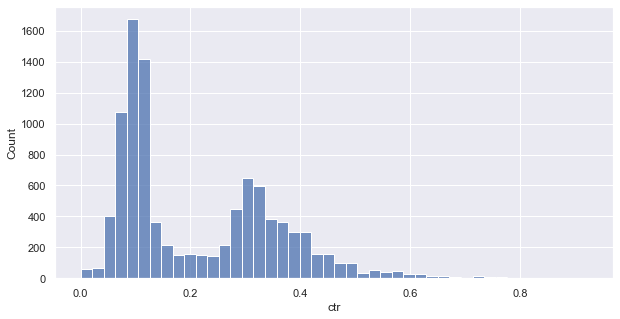

In [110]:
# граница между низким и выоским ctr примерно на 0,2
sns.histplot(data=df_ctr_expand, x='ctr')

In [111]:
df_ctr_expand['2_groups'] = df_ctr_expand.ctr>0.2
df_ctr_expand['2_groups'].replace({True:'high_ctr', False:'low_ctr'}, inplace=True)

In [112]:
# Возраст, пол по 2-м группам не отличаются. 
# Юзеры группы с высоким CTR делают меньше просмотров.
df_ctr_expand.groupby('2_groups').mean().T

2_groups,high_ctr,low_ctr
user_id,74395.694269,75742.651087
exp_group,2.000000,2.000000
likes,20.129061,7.458877
views,59.224278,71.707971
ctr,0.356670,0.100206
age,27.284973,27.196014
gender,0.548962,0.556884


In [113]:
df_ctr_expand[['2_groups','views', 'os']].pivot_table(index='2_groups', columns='os', aggfunc='count', fill_value=0, margins=True)

views            
os       Android   iOS   All
2_groups                    
high_ctr    2908  1524  4432
low_ctr     3501  2019  5520
All         6409  3543  9952

In [114]:
df_ctr_expand[['2_groups','views', 'source']].pivot_table(index='2_groups', columns='source', aggfunc='count', fill_value=0, margins=True)

views              
source     ads organic   All
2_groups                    
high_ctr  2106    2326  4432
low_ctr   2588    2932  5520
All       4694    5258  9952

In [115]:
df_ctr_expand[['2_groups','views', 'country']].pivot_table(index='2_groups', columns='country', aggfunc='count', fill_value=0, margins=True).T

2_groups           high_ctr  low_ctr   All
      country                             
views Azerbaijan         50       60   110
      Belarus            78      126   204
      Cyprus              7        5    12
      Estonia             4        4     8
      Finland            43       65   108
      Kazakhstan         84      112   196
      Latvia              2        5     7
      Russia           3918     4813  8731
      Switzerland         3        7    10
      Turkey             35       47    82
      Ukraine           208      276   484
      All              4432     5520  9952

**Вывод 3**: Особых отличий между группами на предварительном анализе не выявлено. Единственное отличие - у группы с низкий CTR несколько больше (!) просмотров. 